# Latent Dirichlet Allocation Visualizations

This is notebook for visualizing the trained LDA models that had the best performance and number of topics up to 10.

In [1]:
import re, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import codecs
from pprint import pprint
# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.models import CoherenceModel

warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

### Load Data for the use cases 3 & 4

In [2]:
# # Use Case 3
# with open("C:/Users/anast/Desktop/Thesis/MachineLearning/Ontology/DatasetOntology/all.txt") as f:
#     data = f.read().splitlines()

# # Use Case 4
# with open("C:/Users/anast/Desktop/Thesis/MachineLearning/Data/datasetProjects.txt") as f:
#     data = f.read().splitlines()

### Load Data for the use cases 7 & 8

In [3]:
# # Use Case 7
# with open("C:/Users/anast/Desktop/Thesis/MachineLearning/Ontology/DatasetOntology/Th-Ur-all.txt") as f:
#     data = f.read().splitlines()

# Use Case 8
with open("C:/Users/anast/Desktop/Thesis/MachineLearning/Data/Th-Ur-Projects.txt") as f:
    data = f.read().splitlines()

### Number of topics

In [4]:
num_topics = 10

### Preprocessing of data
- Exclude the words of common functioanallity according to the use cases 3,4,7,8
- Clean from numbers, punctuation and stop words
- Lemmatize the words

In [5]:
nlp = spacy.load('en_core_web_lg')

exclude = []
rules = pd.read_csv('C:/Users/anast/Desktop/Results/results-all1.csv')
rules = rules[(rules['Support']>0.2)][['Left Hand Side', 'Right Hand Side']]
exclude.extend(rules['Left Hand Side'].tolist())
exclude.extend(rules['Right Hand Side'].tolist())
exclude = list(dict.fromkeys(exclude))
exclude.extend(['datum', 'administrator', 'log', 'know', 'able', 'ability'])
# exclude = []
# exclude.extend(['able', 'ability'])
# exclude = []

# Clean the data from numbers, punctuation and stop words
clean_corpus = []
for line in data:
    doc = nlp(line)
    cleanData = []
    for token in doc:
        if not token.is_alpha:
            continue
        elif token.is_stop:
            continue
        elif token.pos_ == "PUNCT":
            continue
        elif token.text in exclude:
            continue
        elif token.lemma_ in exclude:
            continue 
        else:
            cleanData.append((token.lemma_).lower())
    clean_corpus.append(cleanData)

### Build the bigram and trigram models

In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(clean_corpus, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[clean_corpus], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

texts = [bigram_mod[doc] for doc in clean_corpus]
texts = [trigram_mod[bigram_mod[doc]] for doc in texts]

data_ready = texts

### Create the dictionary and the corpus in order to build the LDA model

In [7]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

### Format the results

In [8]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.to_csv('dominant_topics.csv')

### Sentence Chart Colored by Topic

- Each word in the document is representative of one of the topics and colored by the topic it is attributed to
- The color of the rectangle is the topic assigned to the document

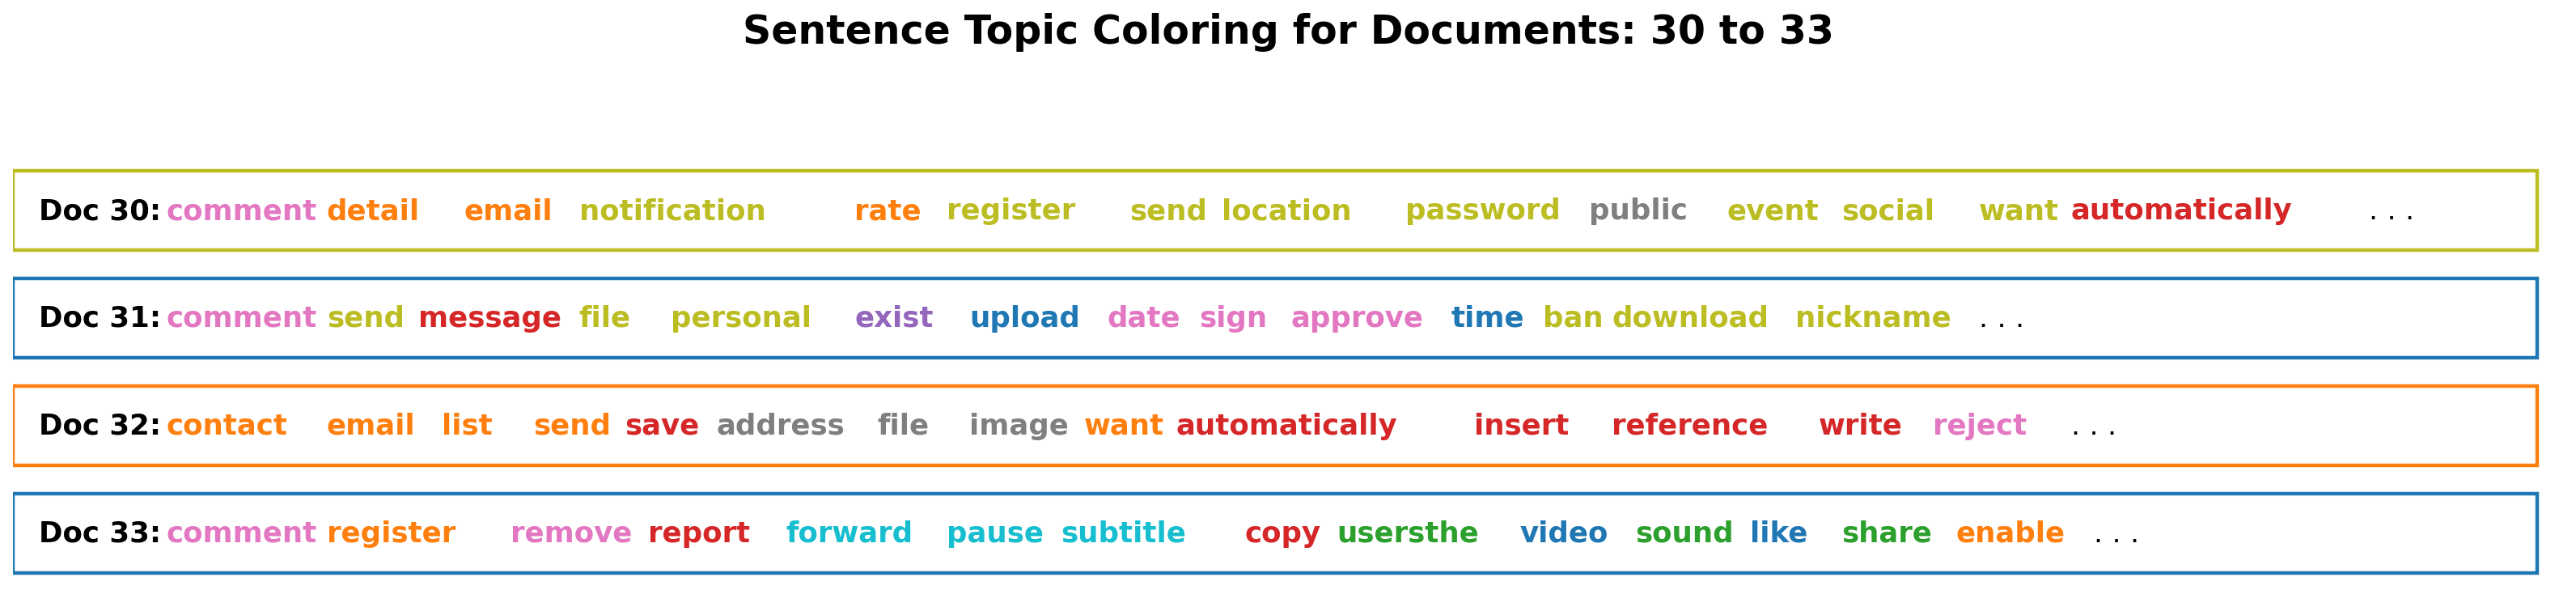

In [9]:

from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 30, end = 35):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1]
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]
            ax.text(0.01, 0.5, "Doc " + str(start+i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1,
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.savefig('Sentence Topic Coloring for Documents.jpg')
    plt.show()
sentences_chart()


### Topics Distribution
- The number of documents for each topic by assigning the document to the topic that has the most weight in that document.
- The number of documents for each topic by by summing up the actual weight contribution of each topic to respective documents.

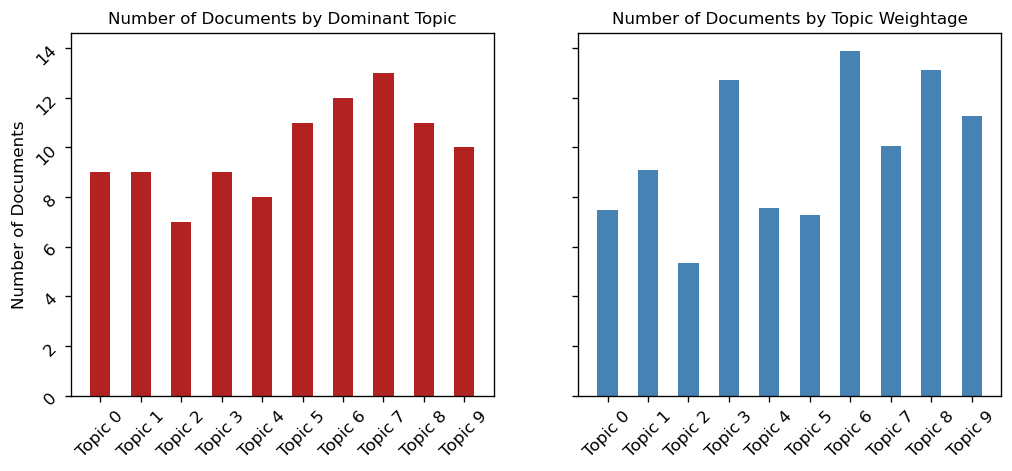

In [10]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False)
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x))
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.tick_params(rotation=45)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
# ax1.set_ylim(0, 15)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.tick_params(rotation=45)

ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))
plt.savefig('DominantTopicAndTopicWeightage.jpg')

### pyLDAvis


In [11]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
pyLDAvis.save_html(vis, 'pyLDAvis.html')
vis

C:\Users\anast\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.253400  0.024096       1        1  13.265990
9     -0.152708  0.238987       2        1  12.706556
3      0.075896 -0.070755       3        1  11.864202
6     -0.098705  0.080208       4        1  11.141496
0     -0.028974 -0.006662       5        1  10.234377
7      0.025461 -0.014059       6        1   9.964417
1      0.149556  0.083224       7        1   9.693249
5     -0.103141 -0.169474       8        1   8.481062
4     -0.082137 -0.172827       9        1   7.507241
2     -0.038648  0.007262      10        1   5.141408, topic_info=               Term       Freq      Total Category  logprob  loglift
40          product  60.000000  60.000000  Default  30.0000  30.0000
53              set  47.000000  47.000000  Default  29.0000  29.0000
1227          salon  32.000000  32.000000  Default  28.0000  28.0000
738        videothe  34.000000  34.000000  Default  27.0000  27.0000
375            post  35.000000  35.000000  Default  26.0000  26.0000
...             ...        ...        ...      ...      ...      ...
1318  parametersthe   1.532106   2.354007  Topic10  -5.2515   2.5384
1319       pointthe   1.532106   2.354007  Topic10  -5.2515   2.5384
1320         remind   1.532106   2.354007  Topic10  -5.2515   2.5384
566           share   7.625252  11.960157  Topic10  -3.6466   2.5177
456         control   5.742775  11.956243  Topic10  -3.9302   2.2345

[390 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
173       1  0.950901       accept
0         3  0.801238       accord
780       2  0.908357  accountsthe
715       2  0.944326   accountthe
362       3  0.914278     activity
...     ...       ...          ...
172       6  0.852555          web
1269      3  0.958633     wishlist
1333      7  0.816985      working
930       2  0.970821    workspace
260       3  0.832678        write

[387 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 10, 4, 7, 1, 8, 2, 6, 5, 3])